# Creating a Blank Jupyter Notebook

In [6]:
# Standard SDXL Turbo Pipeline Setup
# This sets up both standard SDXL Turbo and Impactful NAG pipelines


import sys
import torch
from PIL import Image
from diffusers import (
    UNet2DConditionModel,
    StableDiffusionXLPipeline,
    EulerAncestralDiscreteScheduler,
)

%load_ext autoreload
%autoreload 2

print("✓ Imports completed")

# ---------- Configuration ----------
device = "cuda"
weights_dtype = torch.bfloat16
basemodel_id = "stabilityai/stable-diffusion-xl-base-1.0"

# Turbo UNet source
turbo_repo = "stabilityai/sdxl-turbo"
turbo_subfolder = "unet"

print(f"✓ Configuration set - Device: {device}, Dtype: {weights_dtype}")

# ---------- Base model (to borrow scheduler config) ----------
print("Loading base model for scheduler config...")
base_pipe_for_cfg = StableDiffusionXLPipeline.from_pretrained(
    basemodel_id, torch_dtype=weights_dtype, use_safetensors=True
)
base_sched_config = base_pipe_for_cfg.scheduler.config
del base_pipe_for_cfg  # keep VRAM tidy
print("✓ Base scheduler config loaded")

# ---------- SDXL-Turbo distilled UNet ----------
print("Loading SDXL-Turbo distilled UNet...")
distilled_unet = UNet2DConditionModel.from_pretrained(
    turbo_repo, subfolder=turbo_subfolder, torch_dtype=weights_dtype, variant="fp16"
).to(device, weights_dtype)
print("✓ Distilled UNet loaded")

# ---------- Standard SDXL Turbo Pipeline ----------
print("Setting up standard SDXL Turbo pipeline...")
pipe_std_turbo = StableDiffusionXLPipeline.from_pretrained(
    basemodel_id, unet=distilled_unet, torch_dtype=weights_dtype, variant="fp16", use_safetensors=True
).to(device)
pipe_std_turbo.scheduler = EulerAncestralDiscreteScheduler.from_config(
    base_sched_config, timestep_spacing="trailing"
)
print("✓ Standard SDXL Turbo pipeline ready")

print("\n🎉 Standard SDXL Turbo pipeline loaded successfully!")
print("Available pipeline:")
print("  - pipe_std_turbo: Standard SDXL Turbo")

✓ Imports completed
✓ Configuration set - Device: cuda, Dtype: torch.bfloat16
Loading base model for scheduler config...


Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


✓ Base scheduler config loaded
Loading SDXL-Turbo distilled UNet...
✓ Distilled UNet loaded
Setting up standard SDXL Turbo pipeline...


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 10.30it/s]


✓ Standard SDXL Turbo pipeline ready

🎉 Standard SDXL Turbo pipeline loaded successfully!
Available pipeline:
  - pipe_std_turbo: Standard SDXL Turbo


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]

Generated: An older woman librarian with glasses, sitting at a wooden desk surrounded by books, warm library lighting, professional attire, kind expression
Image size: (512, 512)


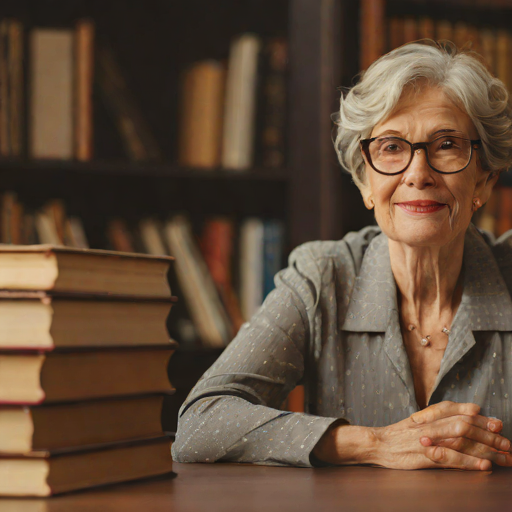

In [2]:
# Generate "Older Woman Librarian" with SDXL Turbo
prompt = "An older woman librarian with glasses, sitting at a wooden desk surrounded by books, warm library lighting, professional attire, kind expression"
seed = 42
num_steps = 4  # Turbo supports 1-4 steps

# Generate the image
generator = torch.Generator(device=device).manual_seed(seed)
image = pipe_std_turbo(
    prompt,
    guidance_scale=0.0,  # Turbo works best with CFG=0 (ADD-style)
    num_inference_steps=num_steps,
    generator=generator,
    width=512, 
    height=512,
).images[0]

print(f"Generated: {prompt}")
print(f"Image size: {image.size}")
image

In [ ]:
# ---------- Standard SDXL Turbo Demonstration ----------
# Compare different settings with standard SDXL Turbo pipeline

prompt = "A bustling marketplace with vendors selling fresh fruits and vegetables"
negative_prompt = "glasses, eyewear, blurry, low quality"
seeds = [2047, 2107, 2207, 2307]  # Using fewer seeds for faster testing

# Turbo settings
STEPS = 4               # Turbo supports 1–4 steps
TURBO_CFG = 0.0         # ADD-style; typically run with CFG ~0

print(f"Settings: {STEPS} steps")
print(f"Prompt: {prompt}")
print(f"Negative prompt: {negative_prompt}")

import pdb, sys, traceback

try:
    rows = []
    for i, s in enumerate(seeds):
        print(f"\nProcessing seed {s} ({i+1}/{len(seeds)})...")
        
        # 1) Standard Turbo (no negatives, CFG=0.0)
        g = torch.Generator(device=device).manual_seed(s)
        img_no_neg_cfg0 = pipe_std_turbo(
            prompt, 
            guidance_scale=0.0, 
            generator=g, 
            num_inference_steps=STEPS,
            width=512, height=512
        ).images[0]
        
        # 2) Standard Turbo (with negatives, CFG=1.0)
        g = torch.Generator(device=device).manual_seed(s)
        img_with_neg_cfg1 = pipe_std_turbo(
            prompt,
            negative_prompt=negative_prompt,
            guidance_scale=1.0,
            generator=g,
            num_inference_steps=STEPS,
            width=512, height=512
        ).images[0]

        # 3) Standard Turbo (no negatives, CFG=2.0)
        g = torch.Generator(device=device).manual_seed(s)
        img_no_neg_cfg2 = pipe_std_turbo(
            prompt, 
            guidance_scale=2.0, 
            generator=g, 
            num_inference_steps=STEPS,
            width=512, height=512
        ).images[0]

        # 4) Standard Turbo (with negatives, CFG=2.0)
        g = torch.Generator(device=device).manual_seed(s)
        img_with_neg_cfg2 = pipe_std_turbo(
            prompt,
            negative_prompt=negative_prompt,
            guidance_scale=2.0,
            generator=g,
            num_inference_steps=STEPS,
            width=512, height=512
        ).images[0]

        rows.append([img_no_neg_cfg0, img_with_neg_cfg1, img_no_neg_cfg2, img_with_neg_cfg2])
        print(f"  ✓ Generated 4 variants for seed {s}")

except Exception as e:
    print(f"Error during generation: {e}")
    traceback.print_exc()
    pdb.post_mortem()

print(f"\n✓ Generated {len(rows)} rows of comparisons")

In [ ]:
# ---------- Create Comparison Grid ----------
if 'rows' in locals() and len(rows) > 0:
    # Assemble comparison grid (rows × 4 columns)
    img_height, img_width = rows[0][0].height, rows[0][0].width
    grid = Image.new('RGB', (img_width * 4, img_height * len(rows)))
    
    for row_idx, row_images in enumerate(rows):
        for col_idx, img in enumerate(row_images):
            grid.paste(img, (col_idx * img_width, row_idx * img_height))

    print("Comparison Grid Layout (Standard SDXL-Turbo, 4-step):")
    print("Column 1: No negatives, CFG=0.0")
    print("Column 2: With negatives, CFG=1.0")  
    print("Column 3: No negatives, CFG=2.0")
    print("Column 4: With negatives, CFG=2.0")
    
    for i, seed in enumerate(seeds):
        print(f"Row {i+1}: Seed {seed}")
    
    # Display the grid
    grid
else:
    print("No images generated yet. Run the previous cell first.")

In [ ]:
# ---------- Simple Sample Image Generation ----------
prompt = "An older female librarian"
num_steps = 4  # Turbo supports 1-4 steps
seed = 42

# Generate with turbo
generator = torch.Generator(device=device).manual_seed(seed)
sample_image = pipe_std_turbo(
    prompt,
    guidance_scale=0.0,  # ADD-style for Turbo
    num_inference_steps=num_steps,
    generator=generator,
    width=512, height=512,
).images[0]

print(f"Generated image: {sample_image.size}")
sample_image

In [7]:
import json
import os
from pathlib import Path
from tqdm import tqdm

# ---------- Load prompts from JSON file ----------
prompts_file = "/home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/data/prompts_noun_negative.json"
output_dir = "/home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/results"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load prompts
with open(prompts_file, 'r') as f:
    prompts_data = json.load(f)

print(f"Loaded {len(prompts_data)} prompts from {prompts_file}")
print(f"Output directory: {output_dir}")

# ---------- Generate and save images ----------
num_steps = 4  # Turbo uses 4 steps
generated_count = 0

for idx, item in enumerate(tqdm(prompts_data)):
    prompt = item["prompt"]
    negative_prompt = item["negative_prompt"]
    seeds = item.get("seeds", [42])
    
    # Use first seed for quick generation
    seed = seeds[0]
    
    try:
        # Generate image
        generator = torch.Generator(device=device).manual_seed(seed)
        image = pipe_std_turbo(
            prompt,
            guidance_scale=0.0,
            num_inference_steps=num_steps,
            generator=generator,
            width=512, height=512,
        ).images[0]
        
        # Create output filename
        group = item.get("group", "unknown")
        filename = f"{idx:04d}_{group}_{seed}.png"
        filepath = os.path.join(output_dir, filename)
        
        # Save image
        image.save(filepath)
        generated_count += 1
        
    except Exception as e:
        print(f"Error generating image for prompt {idx}: {e}")
        continue

print(f"\n✓ Generated and saved {generated_count} images to {output_dir}")

Loaded 160 prompts from /home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/data/prompts_noun_negative.json
Output directory: /home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/results


100%|██████████| 160/160 [01:24<00:00,  1.88it/s]



✓ Generated and saved 160 images to /home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/results
